<a href="https://colab.research.google.com/github/Amalesh-A/GAP/blob/main/Drone_ResourceAllocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---


Install necessary packages

---



In [ ]:
pip install matplotlib

In [ ]:
pip install pandas

In [ ]:
pip install cvxopt

In [ ]:
pip install networkx

In [ ]:
pip install cv

In [ ]:
%matplotlib inline



---


Import libraries and set up an environment for numerical and network analysis,
as well as optimization problems. Specifically, import **matplotlib.pyplot** for plotting graphs, **numpy** for numerical operations, and **pandas** for
data manipulation. Also, import **cvxopt** for solving convex optimization problems, with options set to suppress progress messages during computation. The **networkx** library and its bipartite module are included for creating and manipulating complex networks and graphs. Additional standard libraries like **itertools**, **json**, and **csv** are loaded for more general programming tasks such as iterating in complex ways, handling JSON data, and reading/writing CSV files.

---



In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import numpy as np

In [ ]:
import pandas as pd

In [ ]:
from cvxopt import matrix, spmatrix, solvers

In [ ]:
import networkx as nx

In [ ]:
from networkx.algorithms import bipartite

In [ ]:
import itertools

In [ ]:
import json

In [ ]:
import csv

In [ ]:
import time as tm

In [ ]:
eps = 1e-10
solvers.options['show_progress'] = False



---


In the generalized assignment problem, we are given a collection of 'n' jobs  
to be assigned to 'm' machines. Each job is to be assigned to exactly one machine; if it is assigned to a machine, then it requires
time units of processing, and incurs a cost of c_ij. Furthermore, we are given a time bound that limits the total processing of each machine . The aim is to find a feasible assignment of minimum total cost.

This can be adopted for our problem,
*   Set of missions:

Each mission is represented as a tuple containing several attributes: M = (O, DP, U, R)
where 'O' represents the objective of the mission, 'DP' representes the data products anticipated from the mission, 'U' representst the urgency associated with the mission, while 'R' represents the risk associated.


*   Set of resources:

Each resource is represented as a tuple containing several attributes: R = (PT, PL, PSW, HRI, FL, MAN, SSW)
where 'PT' represents the platform, 'PL' represents the required payload, 'PSW' represents the post-processing software, 'HRI' represents the human-robot interaction support, 'FL' represents the  flight autonomy, 'MAN' represents the necessary manual skills, and 'SSW' represents the required special software for the mission.


---

Calculate an initial solution using linear programming, \\
Construct a graph based on this solution, and then \\
Apply a deterministic rounding technique to refine the solution.

---



In [65]:
def GAP(p,c,T, show=False):
  # Capture the current time and calculate initial linear programming solution
    time0 = tm.perf_counter()
    solution, objective_value, status = LinearPrgSoln(p, c, T)

    # Capture the time immediately after the linear programming solution to calculate the duration of this phase.
    time1 = tm.perf_counter()

    # Check if a valid solution exists
    if solution is None:
      return None, objective_value, status, time1 - time0, np.nan

    # Capture the time before starting the graph building
    time2 = tm.perf_counter()

    # Construct a graph using the solution
    consGraph = graphbuilder(solution, p)
    final = deterministicRounding(consGraph, c, show)

    # Capture the time after completing the deterministic rounding process
    time3 = tm.perf_counter()
    return final, objective_value, status, time1 - time0, time3 - time2



---

Solve the linear programming problem based on the provided processtime matrix, costmatrix, and timebound

---



In [ ]:
def LinearPrgSoln(processtime, costmatrix, timebound):

        # Getting LP dimensions: Extract the dimensions of the processtime matrix.
    x, y = processtime.shape

    # Create an empty array
    arr = np.empty(x*y)

    # Initialize a list to construct a sparse matrix for upper bound constraints.
    UpperboundA = []

    # Construct the upper bound constraint vector by repeating timebound for each constraint
    UpperboundB = np.concatenate((np.full(x, timebound), np.zeros(2*x*y)))

    # Initialize Equality Constraint Matrix
    ECA = np.ones(x*y)

    # Initialize Equality Constraint Vector
    ECB = np.ones(y)

    # Indices for sparse data types
    UpperboundAi = []
    UpperboundAj = []
    ECAi = []
    ECAj = []

    # Construct Coefficients and Constraints
    for i in range(x):
      for j in range(y):

            # construct coefficient vector
            arr[i * y + j] = costmatrix[i, j]

            # construct equality constraint matrix
            ECAi.append(j)
            ECAj.append(i * y + j)

            # construct entries to upper bound matrix
            UpperboundA.append(processtime[i, j])
            UpperboundAi.append(i)
            UpperboundAj.append(i*y+j)
            UpperboundA.append(-1)
            UpperboundAi.append(x + i * y + j)
            UpperboundAj.append(i * y + j)

            # If timebound is a scalar, convert it to an array with the same value for each element
            if isinstance(timebound, (int, float)):
              timebound = np.full(x, timebound)

            if processtime[i, j] > timebound[i]:
              UpperboundA.append(1)
              UpperboundAi.append(x + x * y + i * y + j)
              UpperboundAj.append(i * y + j)

    costVector = matrix(arr)

    constraintMatrix = spmatrix(UpperboundA, UpperboundAi, UpperboundAj, size=(x + 2 * x * y, x * y))

    upperbound = matrix(UpperboundB)

    eqConstraint = spmatrix(ECA, ECAi, ECAj, size=(y, x * y))

    eqTargetValue = matrix(ECB)

    # get LP solution
    solution = solvers.lp(costVector, constraintMatrix, upperbound, eqConstraint, eqTargetValue, solver='glpk')

    if solution['status'] == 'primal infeasible':
      return None, np.nan, solution['status']

    return np.reshape(np.array(solution['x']), (x, y)), solution['primal objective'], solution['status']



---

Convert the LP solution to a bipartite graph with fractional edge weights where one side represents jobs and the other side represents slots.

---



In [ ]:
def graphbuilder(matx, processtime,):

    # Matrix dimensions
    x = matx.shape[0]
    y = matx.shape[1]

    # Initialize the graph array
    grapharr = np.zeros((y, x, y))

    # Loop over drones
    for i in range(x):

        # Current slot in drones i
        s = 0

        # Space left in current slot
        left = 1

        # Sort missions by process time
        xin = np.argsort(-processtime[i])

        # Loop over sorted missions
        for j in xin:

            # Assignment Logic
            yin = matx[i, j]
            if yin <= left:

                # Fit mission in the current slot
                grapharr[j, i, s] = yin
                left -= yin

            else:
                grapharr[j, i, s] = left
                s += 1
                grapharr[j, i, s] = yin - left
                left = 1 - (yin - left)

    return grapharr



---


Deterministicly round the input fractional min-cost perfect matching to a integral one and output it.


---



In [66]:
def deterministicRounding(arr, costmatrix, show=False):

    # Extract dimensions from the Array 'arr'
    x, y, z = arr.shape

    # Initialize an array of size n and fill it with -1
    t_arr = np.ones(x, dtype='int')*(-1)

    # Reshape t_arr
    new_arr = np.reshape(arr, (arr.shape[0], y * z))

    # Preprocessing - Eliminate the edge with weight 1
    for i in range(x):
        for j in range(y * z):
            if(new_arr[i,j] > 1-eps):
                t_arr[i] = j//z
                new_arr[i,j] = 0

    # Assign all the missions
    while(list(t_arr).count(-1) != 0):

        # Find a cycle
        cycle = bipartite(new_arr)

        # Call round_cycle to process the cycle found by bipartite()
        f0 = round_cycle(new_arr, cycle, z, costmatrix)
        # Update the result and the matrix
        if(f0.shape[0] != 0):
            for j in range(f0.shape[0]):
                t_arr[f0[j,0]]= f0[j,1] //z
                new_arr[f0[j,0]][f0[j,1]]=0

    return t_arr


---

Find a cycle or an augmenting path in a bipartite graph.


---



In [ ]:
def bipartite(matx):

    # Initialize lists for tracking
    left = []
    right = []

    # Find non-zero columns
    temp = np.where(np.sum(matx, axis = 0)> eps)[0]

    # Copy of the graph
    dup = np.copy(matx)
    result = rdfs(dup, left, right, temp)
    if(result is None):
        print(dup)
    return result

def ldfs(matx, left, right, l):

    # Initialize the left path
    left.append(-1)

    # Loop over starting nodes
    for i in range(len(l)):

        # Set current node
        left[-1]=l[i]

        # Current node connections
        s = left[-1]
        t = right[-1]

        # Remove edge temporarily
        matx[s,t]=0

        # Find connections
        llist = np.where(matx[left[-1],:] > eps)[0]

        # Checks if the first node in the right list is in the newly found connections,
        # which would indicate a cycle has been completed.
        if(right[0] in llist):

            # If a cycle is detected, appends the start node of right to right to complete the cycle,
            # construct a cycle list with left and right, and return it.
            right.append(right[0])
            cyc = [left, right]
            return cyc

        # Recursive DFS call
        cyc = rdfs(matx, left, right, llist)

        # Cycle found in subsequent calls
        if(cyc != None):
            return cyc

        # Restore edge if no cycle is found
        if(len(right)!= 0):
            matx[s,t]=1

    # Backtrack
    left.pop()
    return None

def rdfs(matx, left, right, l):

    # Initialize the left path
    right.append(-1)

    # Loop over starting nodes
    for i in range(len(l)):

        # Set current node
        right[-1]=l[i]

        # Current node connections
        s = -1
        t = right[-1]

        # Handle existing left path
        if(len(left)>0):
            s = left[-1]
            matx[s,t]=0

        # Find connections
        rlist = np.where(matx[:,t] >eps)[0]

        # Cycle completion check
        if(rlist.shape[0] == 0):
            if(np.where(matx[:,right[0]]>eps)[0].shape[0] == 0):
                cycle = [left, right]
                return cycle

        # Recursive DFS call
        cycle = ldfs(matx, left, right, rlist)

        # Cycle found in subsequent calls
        if(cycle != None):
            return cycle

        # Restore edge if no cycle is found
        if(len(left)>0):
            matx[s,t]=1

    # Backtrack
    right.pop()
    return None


---
Adjust the matrix representing a solution to adhere more closely to integer
constraints by rounding values within a specified cycle. It determines the optimal rounding direction based on the costs and adjusts the matrix elements accordingly, ensuring that no element exceeds 1 or falls below 0 while trying to minimize the cost.

---




In [ ]:
def round_cycle(arr, cycle, k, costmatrix):

    # Initialize variables
    dir = 0
    length = len(cycle[0])
    for i in range(length):
        dir += costmatrix[cycle[1][i]// k][cycle[0][i]]-costmatrix[cycle[1][i+1]// k][cycle[0][i]]

    if(dir > eps):
        cycle[0] = cycle[0][::-1]
        cycle[1] = cycle[1][::-1]

    x_1 = np.amin([1-arr[cycle[0][i], cycle[1][i]] for i in range(length)])
    x_2 = np.amin([arr[cycle[0][i], cycle[1][i+1]] for i in range(length)])
    mini_mum = min([x_1, x_2])
    f0 = []
    current = cycle[1][0]
    for i in range(length):

        m = cycle[0][i]
        arr[m][current] +=  mini_mum
        if(arr[m][current] > 1-eps):
            f0.append([m, current])

        current = cycle[1][i+1]
        arr[m][current] -=  mini_mum
        if(arr[m][current] < eps):
            arr[m][current] = 0

    return np.array(f0)



---


Calculate the total cost of a solution represented by the 'final' array, where each element in final specifies a chosen option for each index, and the costmatrix provides the associated costs for these choices. It sums up the costs for all valid (non-negative) choices in the solution.

---



In [ ]:
def costfactor(final, costmatrix):
    x = 0
    for z in range(len(final)):
        if(final[z]>= 0):
            x += costmatrix[final[z], z]
    return x


---

Compute the total processing time for each option in a given scenario. It does this by iterating through the final array, where each element indicates the chosen option for an index, and adds the corresponding processing times from the processtime matrix to the appropriate option in a cumulative sum array x.

---


In [ ]:
def timefactor(final, processtime):
    x = np.zeros((processtime.shape[0]))
    for z in range(len(final)):
        x[final[z]]+= processtime[final[z], z]
    return x



---
Calculate the total cost of a configuration described by the matrix arr, which contains allocation information across multiple options. It multiplies each element of arr by the corresponding cost in costmatrix and sums up these values to compute the overall cost for the entire configuration, considering all possible combinations of options and allocations.

---



In [ ]:
def cost_arr(arr, costmatrix, n, m):
    x = 0
    for i in range(n):
        for j in range(m):
            for k in range(n):
                x += costmatrix[j,i] * arr[i,j*n+k]
    return x

In [ ]:
cf = 3
pf = 2
y = 20
x = 5
for i in range(100):
    costmatrix = np.exp(cf * np.random.rand(x, y))
    processtime = np.exp(pf * np.random.rand(x, y))
    timebound = np.sum(processtime) * np.random.rand() * 0.05 * np.ones(x)
    final, z0, msg, t_LP, t_Round = GAP(processtime, costmatrix, timebound)
    if(final is None):
        if msg == 'primal infeasible':
            print("Problem appears to be infeasible.")
        if msg == 'unknown':
            print("Status unknown.")
    else:
        if msg == 'unknown':
            print("Terminated early.")
        print(final, z0, costfactor(final, costmatrix), timebound[0], np.amax(timefactor(final, processtime)))

[1 0 3 3 4 4 0 3 2 3 3 2 0 1 2 4 1 2 1 4] 34.91614768243793 34.72684355179838 14.923489879819371 19.456021189912722
[4 2 0 0 0 3 0 3 1 4 3 4 1 2 3 2 3 4 1 1] 59.919229620069125 51.0377925105965 6.6161957591610205 8.85000597874099
[1 2 2 3 1 3 0 4 2 2 3 4 0 0 3 1 3 3 2 1] 50.003592995035234 45.86302181135419 10.257650257542311 13.520001363587808
Problem appears to be infeasible.
[0 3 3 1 3 3 4 3 2 4 2 2 4 0 1 0 4 1 1 4] 37.56521969004278 37.19886177205078 13.875225385497055 14.921822627056155
[4 3 0 4 0 1 4 1 0 0 2 1 1 0 2 2 2 4 1 2] 43.83837167629413 43.54038628530887 12.335884929026511 13.59758676262377
[0 0 1 0 3 4 2 1 4 1 1 2 3 4 0 1 4 0 2 2] 87.39409685323469 80.81220790312153 6.308837765672919 8.678760033232608
[2 4 3 0 2 3 3 0 4 3 1 0 2 0 4 1 3 4 1 2] 111.69538528146379 97.84876280733673 5.82251537597441 7.215152753779826
[4 3 4 1 2 1 4 0 4 0 2 3 0 3 2 1 3 1 0 2] 61.42973537150969 51.33145570558546 6.730567293837867 10.707418877350985
[2 1 0 2 1 2 0 3 3 4 1 4 2 1 0 4 3 4 4 2] 32.

In [ ]:
def read_file(filejson):
    x1 = json.load(filejson)
    processtime = np.array(x1['req'], dtype='float')
    cost = np.array(x1['cost'], dtype='float')
    time = np.array(x1['cap'], dtype='float')
    return processtime, cost, time

# get data table of ids, LP vals, and opt vals and/or UB
data_items = {}
ids_list = []
with open('data.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        idee = row[0]
        ids_list.append(idee)
        data_items[idee] = {'n': row[1], 'm': row[2], 'LP': row[3], 'opt': row[4], 'UB': row[5]}

In [57]:
# Run benchmark tests
for idee in ids_list:
    #print(idee)
    d = data_items[idee]
    try:
        #print(idee)
        # Attempt to open and read the file
        with open(idee + '.json', 'r') as file:
            print(idee)
            process, cost, time = read_file(file)
    except Exception as e:
        #print(f"Failed to read {idee}.json: {e}")
        continue  # Skip to the next file
    #process, cost, time = read_file(open(idee + '.json'))
    #res, f, s, t_LP, t_Round = GAP(process, cost, time)
    #final, z0, msg, t_LP, t_Round = GAP(processtime, costmatrix, timebound)
    final, z0, msg, t_LP, t_Round = GAP(process, cost, time)
    d['timeLP'] = t_LP
    d['timeRound'] = t_Round
    d['status'] = msg
    if(final is None):
        d['algLP'] = np.nan
        d['algcost'] = np.nan
        d['algT'] = [np.nan]
        d['T'] = [np.nan]
        if msg == 'primal infeasible':
            print("Problem appears to be infeasible.")
        if msg == 'unknown':
            print("Status unknown.")
    else:
        if msg == 'unknown':
            print("Terminated early.")
        d['algLP'] = z0
        d['algcost'] = costfactor(final, cost)
        d['algT'] = timefactor(final, process)
        d['T'] = time
        # Calculate the necessary metrics, including cost and time metrics,
        # as well as ratios of calculated processing times to given time constraints
        # Printing algorithmic cost and optimal value
        print('\t', d['algcost'], d['opt'], d['algLP'], d['LP'])
        print('\t', d['algT'])
        print('\t', d['T'])
        # print list of ratios of times
        print('\t', [format(d['algT'][i]/d['T'][i], '.2f') for i in range(len(d['algT']))])

gapa_0
	 1696.0 1698 1697.7272727272725 1697.73
	 [267. 301. 282. 318. 361.]
	 [342. 342. 342. 342. 342.]
	 ['0.78', '0.88', '0.82', '0.93', '1.06']
gapa_1
	 3234.0 3235 3234.739130434782 3234.74
	 [688. 612. 523. 534. 623.]
	 [671. 671. 671. 671. 671.]
	 ['1.03', '0.91', '0.78', '0.80', '0.93']
gapa_2
	 1358.0 1360 1358.556923076923 1358.56
	 [192. 146. 202. 131.  95. 195. 112. 192. 184.  66.]
	 [192. 192. 192. 192. 192. 192. 192. 192. 192. 192.]
	 ['1.00', '0.76', '1.05', '0.68', '0.49', '1.02', '0.58', '1.00', '0.96', '0.34']
gapa_3
	 2623.0 2623 2623.0 2623
	 [245. 387. 351. 326. 239. 283. 365. 279. 266. 274.]
	 [365. 365. 365. 365. 365. 365. 365. 365. 365. 365.]
	 ['0.67', '1.06', '0.96', '0.89', '0.65', '0.78', '1.00', '0.76', '0.73', '0.75']
gapa_4
	 1157.0 1158 1157.08 1157.08
	 [ 20. 104. 109.  91.  78.  62.  87.  31. 102.  98.  47.  42.  95.  84.
   0. 103.  89.  99.  90.  57.]
	 [100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 

In [58]:
# write data
with open('benchmark_data_glpk3.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['id', 'n', 'm', 'status', 'LP', 'algLP', 'opt', 'UB', 'algcost', 'algmaxTratio', 'timeLP', 'timeRound'])
    for idee in ids_list:
        d = data_items[idee]
        status = d.get('status', 'N/A')
        algLP = d.get('algLP', 'N/A')
        algcost = d.get('algcost', 'N/A')
        timeLP = d.get('timeLP', 'N/A')
        timeRound = d.get('timeRound', 'N/A')
        if 'algT' in d:
            algT_ratio = max([d['algT'][i] / d['T'][i] for i in range(len(d['algT']))])
        else:
            algT_ratio = 'N/A'

        writer.writerow([idee, d['n'], d['m'], status, d['LP'], algLP, d['opt'], d['UB'], algcost, algT_ratio , timeLP, timeRound])

In [59]:
def draw(x, cycle, show=False):
    # Early Return
    if (show==False):
        return

    # Setup cycle edges
    cycle_edges = []
    for idx, j in enumerate(cycle[-1]):
        # Add edges in addition
        if idx != 0:
            cycle_edges.append(("i{}".format(cycle[0][idx-1]), "j{}".format(j)))
        if idx != len(cycle[-1])-1:
            cycle_edges.append(("j{}".format(j),"i{}".format(cycle[0][idx])))

    # Initialize the Graph
    B = nx.Graph()
    B.add_nodes_from(['i{}'.format(i) for i in range(x.shape[0])], bipartite=0)
    B.add_nodes_from(['j{}'.format(i) for i in range(x.shape[1])], bipartite=1)

    # Add edges from the matrix
    B.add_edges_from([('i{}'.format(i),'j{}'.format(j))
                      for i,j in itertools.product(range(x.shape[0]), range(x.shape[1]))
                      if x[i,j]])

    # Setup edge colors
    edge_color = []
    for edge in B.edges():
        if edge not in cycle_edges and (edge[-1],edge[0]) not in cycle_edges:
            edge_color.append(-100)
        else:
            try:
                idx = cycle_edges.index(edge)
            except:
                idx = cycle_edges.index((edge[-1],edge[0]))
            edge_color.append(idx%2)

    # Calculate positions
    X = set(n for n,d in B.nodes(data=True) if d['bipartite']==0)
    Y = set(B) - X
    pos = dict()
    pos.update( (n, (1, int(n[1:])*60)) for i, n in enumerate(X) )
    pos.update( (n, (2, int(n[1:])*30)) for i, n in enumerate(Y) )

    # Draw graphs
    nx.draw_networkx(B, pos=pos, with_labels=1, node_size=400,edge_color=edge_color,
                     edge_cmap=plt.get_cmap('Paired'), edge_vmin=-1, edge_vmax=1, width=4)

    plt.show()

In [60]:
# Initialize variables
cf = 3
pf = 2
n = 5
m = 2
from tqdm import *

# Setup simulation
for i in tqdm([78]):

    # Generate the matrix
    np.random.seed(i)
    cost = np.exp(cf*np.random.rand(m,n))
    process = np.exp(pf*np.random.rand(m,n))

    # total time constraint
    time = np.sum(process)*np.random.rand()

    # Call the GAP function with the matrices P and C, and the time constraint T.
    final, z0, *_ = GAP(process, cost, time, show=True)
    if(final is None):
        print("There is no feasible solution!")
    else:
        print(final, z0, costfactor(final, cost), time, timefactor(final, process))

100%|██████████| 1/1 [00:00<00:00, 329.82it/s]

[0 0 1 0 1] 30.602917768722925 26.3063074961493 8.752311299335453 [11.62016076  8.80089016]


In [61]:
# Setup variables
cf = 3
pf = 2
from tqdm import *
np.random.seed(0)

# Generate random matrices C and P using the dimensions 'm' by 'n' and predefined scaling factors 'cf' and 'pf'.
def perf(y, x, cf, pf):
    for z in (range(1)):
        cost = np.exp(cf * np.random.rand(x, y))
        process = np.exp(pf * np.random.rand(x, y))
        time = np.sum(process) * np.random.rand()
        res, f, *_ = GAP(process, cost, time)

# Benchmarking
%timeit perf(10, 5, cf, pf)
%timeit perf(50, 5, cf, pf)
%timeit perf(100, 5, cf, pf)
%timeit perf(300, 5, cf, pf)
%timeit perf(500, 5, cf, pf)
#%timeit perf(1000, 5, cf, pf)
#%timeit perf(5000, 20, cf, pf)

2.36 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
29.5 ms ± 952 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
70.3 ms ± 4.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
570 ms ± 18.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.89 s ± 553 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# Create dataframes
# data_frame = pd.DataFrame.from_dict({10:0.00954, 50:0.0567, 100:0.159, 300:1.23, 500:2.05, 1000:6.27},orient='index')

# Sort the dataframe
# sorted_data_frame = data_frame.sort_index()

# Plot the graph
# sorted_data_frame.plot()

import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame from a dictionary with an appropriate column name
data_frames = pd.DataFrame.from_dict({10: 0.00954, 50: 0.0567, 100: 0.159, 300: 1.23, 500: 2.05, 1000: 6.27}, orient='index', columns=['Execution Time'])

# Sort the DataFrame by index (problem size)
sorted_data_frames = data_frames.sort_index()

# Plotting the DataFrame
# Adding markers for each data point
ax = sorted_data_frames.plot(figsize =(10, 5), linestyle='-', color='r')

# Title of the plot
ax.set_title('Execution Time vs Mission')

# X-axis label
ax.set_xlabel('Mission')

# Y-axis label
ax.set_ylabel('Execution Time (seconds)')

# Adding a grid for better readability
plt.grid(True)

# Display the plot
plt.show()

In [ ]:
# Initialize the variables
cf = 3
pf = 2
from tqdm import *
np.random.seed(0)

# Take the number of missions (n), number of drones (m), and two factors (cf and pf) that influence the range of values in the matrices C and P.
def perf(y, x, cf, pf):
    for i in (range(1)):
        cost = np.exp(cf * np.random.rand(x, y))
        process = np.exp(pf * np.random.rand(x, y))
        time = np.sum(process) * np.random.rand()
        final, z0, *_ = GAP(process, cost, time)

# Benchmarking
%timeit perf(500, 2, cf, pf)
%timeit perf(500, 5, cf, pf)
%timeit perf(500, 10, cf, pf)
%timeit perf(500, 20, cf, pf)
%timeit perf(500, 30, cf, pf)
#%timeit perf(500, 50, cf, pf)
#%timeit perf(500, 100, cf, pf)
#%timeit perf(500, 500, cf, pf)

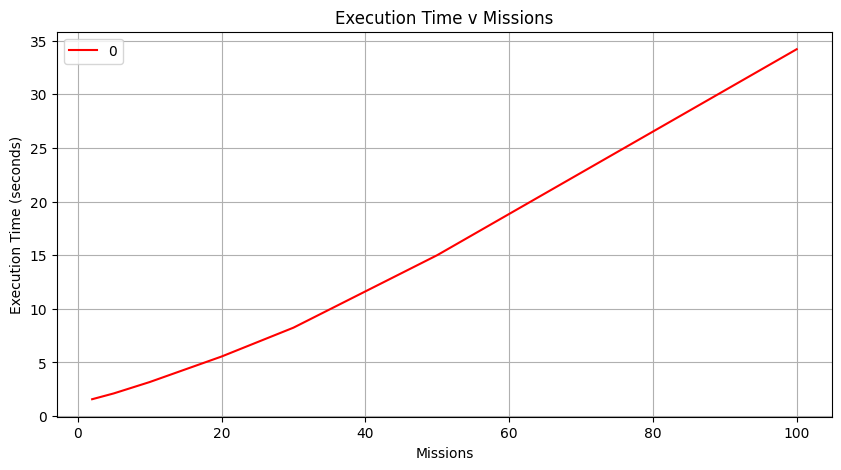

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# Dictionary of data
dic = {2: 1.57, 5: 2.11, 10: 3.17, 20: 5.55, 30: 8.24, 50: 15, 100: 34.2}

# Create DataFrame from dictionary
data_frames = pd.DataFrame.from_dict(dic, orient='index')

# Sort DataFrame by index (number of machines)
sorted_data_frame = data_frames.sort_index()

# Add markers, line, and set color
ax = sorted_data_frame.plot(linestyle='-', color='r', figsize=(10, 5))
# Title of the plot
ax.set_title('Execution Time v Missions')
# X-axis label
ax.set_xlabel('Missions')
# Y-axis label
ax.set_ylabel('Execution Time (seconds)')
# Add grid for better readability
plt.grid(True)
# Display the plot
plt.show()